# Tutorial

Welcome to this tutorial on using OpenFLASH! This guide demonstrates how to set up a multi-body hydrodynamic problem, run the simulation engine, and analyze the results.

OpenFLASH uses the **Matched Eigenfunction Expansion Method (MEEM)** to efficiently analyze wave interactions with concentric structures, providing key hydrodynamic insights like added mass, damping, and potential fields.

---

## 1. Prerequisites and Setup

Before you begin, make sure you have installed the `openflash` package. If you haven't, you can install it using `pip`. It's highly recommended to do this within a virtual environment.

```bash
# Install the package from your local project directory
pip install open-flash
```

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)

<class 'module'>
['/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash']
/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash/__init__.py
OpenFLASH modules imported successfully!


In [2]:
# ---------------------------------
# --- 1. Problem Setup ---
# ---------------------------------
print("\n--- 1. Setting up the Problem ---")
h = 1.001            # Water Depth (m)
d_list = [0.5, 0.25]   # Step depths (m) for inner and outer bodies
a_list = [0.5, 1.0]    # Radii (m) for inner and outer bodies
NMK = [30, 30, 30]     # Harmonics for inner, middle, and exterior domains

m0 = 1.0    # Non-dimensional wave number
problem_omega = omega(m0, h, g)
print(f"Wave number (m0): {m0}, Angular frequency (omega): {problem_omega:.4f}")


--- 1. Setting up the Problem ---
Wave number (m0): 1.0, Angular frequency (omega): 2.7341


In [3]:
def run_simulation(heaving_list, case_name):
    """Sets up geometry, problem, and engine for a specific heaving configuration."""
    print(f"\n--- Running Simulation: {case_name} ---")
    
    # 1. Create Bodies
    bodies = []
    for i in range(len(a_list)):
        body = SteppedBody(
            a=np.array([a_list[i]]),
            d=np.array([d_list[i]]),
            slant_angle=np.array([0.0]), 
            heaving=heaving_list[i]
        )
        bodies.append(body)

    # 2. Arrangement
    arrangement = ConcentricBodyGroup(bodies)

    # 3. Geometry
    geometry = BasicRegionGeometry(
        body_arrangement=arrangement,
        h=h,
        NMK=NMK
    )

    # 4. Problem
    problem = MEEMProblem(geometry)
    problem.set_frequencies(np.array([problem_omega]))
    
    # 5. Engine
    engine = MEEMEngine(problem_list=[problem])
    
    # 6. Solve
    print(f"Solving for {case_name}...")
    X = engine.solve_linear_system_multi(problem, m0)
    
    # 7. Coefficients
    coeffs = engine.compute_hydrodynamic_coefficients(problem, X, m0)
    
    return problem, X, coeffs


## 2. Case 1: Inner Body Heaving (Mode 0)

We simulate the case where only the inner body is heaving (`heaving_list = [True, False]`).

In [4]:
problem1, X1, coeffs1 = run_simulation([True, False], "Inner Body Heaving")

print("\nHydrodynamic Coefficients (Mode 0):")
if coeffs1:
    print(pd.DataFrame(coeffs1))


--- Running Simulation: Inner Body Heaving ---
Solving for Inner Body Heaving...

Hydrodynamic Coefficients (Mode 0):
   mode        real        imag  excitation_phase  excitation_force
0     0  288.113192  188.447876         -0.521015         63.283109
1     1  593.957964  590.899836         -0.521015         84.210930


/Users/hopebest/Documents/semi-analytical-hydro/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.46955e-30): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


## 3. Case 2: Outer Body Heaving (Mode 1)

Now we simulate the case where only the outer body is heaving (`heaving_list = [False, True]`).

**Note:** Currently, the package calculates the diagonal terms of the hydrodynamic coefficient matrix. Off-diagonal (coupling) terms are not yet implemented, so we run separate problems for each mode.

In [5]:
problem2, X2, coeffs2 = run_simulation([False, True], "Outer Body Heaving")

print("\nHydrodynamic Coefficients (Mode 1):")
if coeffs2:
    print(pd.DataFrame(coeffs2))


--- Running Simulation: Outer Body Heaving ---
Solving for Outer Body Heaving...

Hydrodynamic Coefficients (Mode 1):
   mode        real         imag  excitation_phase  excitation_force
0     0  341.504733   590.899825         -0.521015         84.210929
1     1  930.881906  1852.833881         -0.521015        112.059612


/Users/hopebest/Documents/semi-analytical-hydro/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.46955e-30): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


## 4. Potential Field Visualization

We can visualize the potential field for Case 2 (Outer Body Heaving).

Calculating potentials on grid...
Plotting...


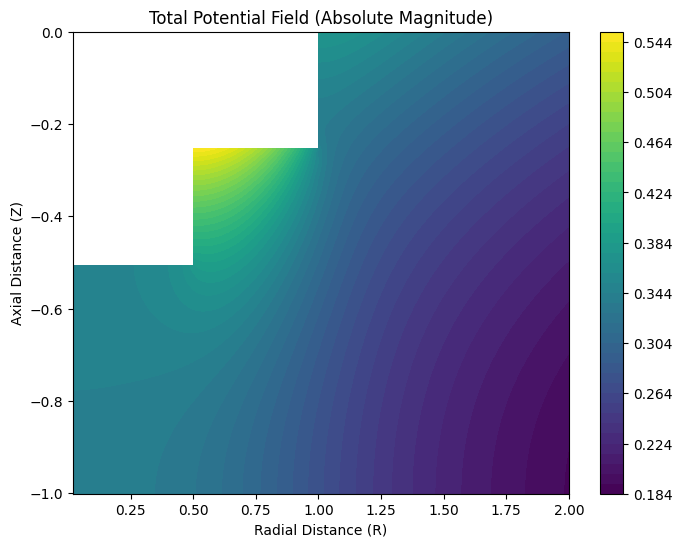

In [6]:
# 1. Re-initialize Engine for Visualization
engine_viz = MEEMEngine([problem2])

# 2. Calculate Potentials
print("Calculating potentials on grid...")
potentials = engine_viz.calculate_potentials(
    problem=problem2,
    solution_vector=X2,
    m0=m0,
    spatial_res=100,
    sharp=True
)

# 3. Extract Fields
R = potentials['R']
Z = potentials['Z']
phi_abs = np.abs(potentials['phi'])

# 4. Plot
print("Plotting...")
fig, ax = engine_viz.visualize_potential(phi_abs, R, Z, "Total Potential Field (Absolute Magnitude)")
plt.show()

## 5. Domain Analysis

We can inspect the fluid domains created by the `BasicRegionGeometry`.

In [7]:
print("\n--- Inspecting Fluid Domains ---")
domains = problem2.geometry.domain_list

for idx, domain in domains.items():
    print(f"Domain {idx} ({domain.category}):")
    outer_str = f"{domain.a_outer:.2f}" if domain.a_outer != np.inf else "inf"
    print(f"  Radii: {domain.a_inner:.2f} m to {outer_str} m")
    print(f"  Lower Depth: {domain.d_lower:.2f} m")
    print(f"  Harmonics: {domain.number_harmonics}")



--- Inspecting Fluid Domains ---
Domain 0 (interior):
  Radii: 0.00 m to 0.50 m
  Lower Depth: 0.50 m
  Harmonics: 30
Domain 1 (interior):
  Radii: 0.50 m to 1.00 m
  Lower Depth: 0.25 m
  Harmonics: 30
Domain 2 (exterior):
  Radii: 1.00 m to inf m
  Lower Depth: 0.00 m
  Harmonics: 30


## 6. Storing and Exporting Results

The `Results` class (based on `xarray`) provides a structured way to store simulation data. Since we ran two separate simulations (one per mode), we will manually aggregate the results into a single dataset containing the full 2x2 added mass and damping matrices.

In [8]:
# 1. Initialize Results object for the FULL system
# We explicitly pass the modes [0, 1] so the container can hold the full matrix,
# even though problem2 only had mode 1 active.
all_modes = np.arange(len(a_list)) # [0, 1]
results = Results(problem2, modes=all_modes)

# 2. Construct Full Matrices from Separate Mode Results
# Shape: (n_freqs, n_modes, n_modes)
n_freqs = len(problem2.frequencies)
n_modes = len(all_modes) 

added_mass = np.zeros((n_freqs, n_modes, n_modes))
damping = np.zeros((n_freqs, n_modes, n_modes))

# Helper to fill matrix columns
# coeffs_list contains entries for row_idx (force on body i)
# col_idx (motion of body j) is determined by which case we ran
def fill_matrix_col(coeffs_list, col_idx):
    for c in coeffs_list:
        row_idx = c['mode'] # Force on body i
        added_mass[0, row_idx, col_idx] = c['real']
        damping[0, row_idx, col_idx] = c['imag']

# Fill Column 0 (Inner Body Heaving results -> Mode 0)
if coeffs1:
    fill_matrix_col(coeffs1, 0)

# Fill Column 1 (Outer Body Heaving results -> Mode 1)
if coeffs2:
    fill_matrix_col(coeffs2, 1)

# 3. Store in Results Object
results.store_hydrodynamic_coefficients(
    frequencies=problem2.frequencies,
    added_mass_matrix=added_mass,
    damping_matrix=damping
)

# 4. View Dataset
print("\n--- Results Dataset (xarray) ---")
print(results.dataset)

# 5. Export (Optional)
# results.export_to_netcdf("tutorial_results.nc")


Hydrodynamic coefficients stored in xarray dataset.

--- Results Dataset (xarray) ---
<xarray.Dataset> Size: 104B
Dimensions:     (frequency: 1, mode_i: 2, mode_j: 2)
Coordinates:
  * frequency   (frequency) float64 8B 2.734
  * mode_i      (mode_i) int64 16B 0 1
  * mode_j      (mode_j) int64 16B 0 1
Data variables:
    added_mass  (frequency, mode_i, mode_j) float64 32B 288.1 341.5 594.0 930.9
    damping     (frequency, mode_i, mode_j) float64 32B 188.4 ... 1.853e+03
